SelectFromModel 是一个基础分类器，其根据重要性权重选择特征。可与拟合后具有coef_或feature_importances_属性的任何估计器一起使用。如果相应的coef_或feature_importances_值低于提供的threshold参数，则这些特征可以认为不重要或者删除。除了指定数值阈值参数，还可以使用字符串参数查找阈值，参数包括：“mean”, “median” 以及这两个参数的浮点数乘积，例如“0.1*mean”。与threshold标准结合使用时，可以通过max_features参数限制选择的特征数量。

In [1]:
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

# 1 SelectFromModel基础使用

主要参数说明如下：
+ threshold：用于特征选择的阈值。保留重要性更高或相等的特征，而其特征则被丢弃。threshold为特征重要性的mean或者median，如果为None，并且估计器的参数惩罚显式或隐式设置为l1（例如Lasso），则使用的阈值为1e-5。否则，默认情况下使用mean。
+ prefit：预设模型是否期望直接传递给构造函数。
+ norm_order：在估算器threshold的coef_属性为维度2 的情况下，用于过滤以下系数矢量的范数的顺序
+ max_features：要选择的最大特征数

基础使用方法如下：

In [2]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
X = [[ 0.87, -1.34,  0.31 ],
     [-2.79, -0.02, -0.85 ],
     [-1.34, -0.48, -2.55 ],
     [ 1.92,  1.48,  0.65 ]]
y = [0, 1, 0, 1]
# 建立评估器
selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)
# estimator的模型参数
print("estimator的模型参数",selector.estimator_.coef_)

# 根据estimator中特征重要性均值获得阈值
print("用于特征选择的阈值；",selector.threshold_)

# 哪些特征入选最后特征，true表示入选
print("特征是否保留",selector.get_support())
# 获得最后结果
print("特征提取结果",selector.transform(X));


estimator的模型参数 [[-0.32857694  0.83411609  0.46668853]]
用于特征选择的阈值； 0.5431271870420733
特征是否保留 [False  True False]
特征提取结果 [[-1.34]
 [-0.02]
 [-0.48]
 [ 1.48]]


**下面演示从糖尿病数据集中选择两个最重要的特征，而无需事先知道阈值。**

使用SelectFromModel和Lasso回归模型可以从糖尿病数据集中选择最佳的特征。由于L1规范促进了特征的稀疏性，我们可能只对从数据集中选择最有趣特征的子集感兴趣。本示例说明如何从糖尿病数据集中选择两个最有趣的特征。

糖尿病数据集由从442名糖尿病患者中收集的10个变量（特征）组成。此示例显示了如何使用SelectFromModel和LassoCv查找预测从基线开始一年后疾病进展的最佳两个特征。



In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

首先，让我们加载sklearn中可用的糖尿病数据集。然后，我们将看看为糖尿病患者收集了哪些特征：

In [4]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

feature_names = diabetes.feature_names
print(feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


为了确定功能的重要性，我们将使用LassoCV估计器。具有最高绝对值的特征coef_被认为是最重要的。sklearn中coef_说明见：[https://www.jianshu.com/p/6a818b53a37e](https://www.jianshu.com/p/6a818b53a37e)



In [5]:
clf = LassoCV().fit(X, y)
# 模型参数的绝对值
importance = np.abs(clf.coef_)
print("十个特征的重要性：",importance);

十个特征的重要性： [  0.         226.2375274  526.85738059 314.44026013 196.92164002
   1.48742026 151.78054083 106.52846989 530.58541123  64.50588257]


接下来我们可以从具有最高分数的模型特征中过滤特征。现在我们要选择两个最重要特征electFromModel()允许设置阈值。仅保留coef_高于阈值的特征。在这里，我们希望将阈值设置为略高于coef_。LassoCV()根据数据计算出高于第三高特征的高阈值。





In [6]:
# 对重要性进行排名
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01
print('阈值为',threshold)
idx_features = (-importance).argsort()[:2]
name_features = np.array(feature_names)[idx_features]
print('重要性第三大的特征: {}'.format(name_features))

sfm = SelectFromModel(clf, threshold=threshold);
sfm.fit(X, y)

# X_transform为特征提取结果
X_transform = sfm.transform(X)
# 提取的特征数
n_features = sfm.transform(X).shape[1]

阈值为 314.4502601292063
重要性第三大的特征: ['s5' 'bmi']


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False,
        threshold=314.4502601292063)

最后，我们将绘制从数据中选择的两个特征。



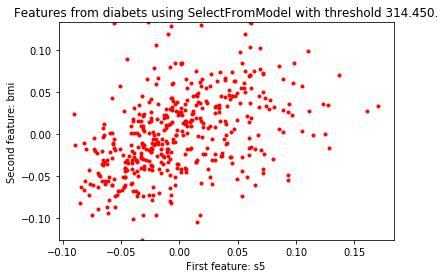

In [7]:
plt.title(
    "Features from diabets using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("First feature: {}".format(name_features[0]))
plt.ylabel("Second feature: {}".format(name_features[1]))
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show();

# 2 SelectFromModel中不同的特征选择方法

## 2.1 基于L1范式进行特征选择
用L1范数惩罚的线性模型具有稀疏解：它们的许多估计系数为零。当目标是减少数据的维数以用于另一个分类器时，它们可以与特征一起使用。L1正则化将系数l1范数作为惩罚项添加损失函数上，由于正则项非零，这就迫使那些弱的特征所对应的系数变成0。因此L1正则化往往会使学到的模型很稀疏（系数w经常为0），这个使得L1正则化成为一种常用的征选择方法。特别的用于此目的的稀疏估计量是linear_model.Lasso用于回归，和linear_model.LogisticRegression以及svm.LinearSVC 用于分类。

简单实例如下：

In [8]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = load_iris(return_X_y=True)
X.shape

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape


(150, 4)

(150, 3)

对于SVM和logistic回归，参数C控制稀疏性：C越小，选择的特征就越少。使用Lasso，alpha参数越高，选择的特征就越少。



## 2.2 基于树的特征选择
基于树的评估器可以被用来计算特征的重要性，然后可以根据特征的重要性去除不相关的特征 (当配合sklearn.feature_selection.SelectFromModel meta-transformer):

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X, y = load_iris(return_X_y=True)
X.shape

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
print("特征重要性",clf.feature_importances_)  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
# 最后保留的特征数
X_new.shape     

(150, 4)

特征重要性 [0.07293638 0.06131363 0.44503667 0.42071333]


(150, 2)

以下例子展示了如何使用随机森林来评估人工分类任务中特征的重要性。红色柱状表示特征的重要性及标准差。不出所料，该图表明3个特征是有信息的，而其余特征则没有。

Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


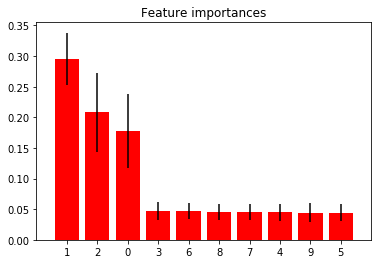

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
# 构造一个数据集，特征数为10，但是有效特征只有三个
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the impurity-based feature importances
# 通过随机森林进行分类，并计算各个特征的重要性
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
# 获得重要性
importances = forest.feature_importances_
# 计算标准差
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# 获得特征排名结果
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
# 画出各个特征的重要性
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]]);

以下示例显示了在图像分类任务（面部）中使用随机森林评估像素点中特征的重要性。像素的热值越高，表明该点对于人脸分类越重要。



Fitting ExtraTreesClassifier on faces data with 1 cores...


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=128, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

done in 1.018s


Text(0.5,1.05,'Pixel importances with forests of trees')

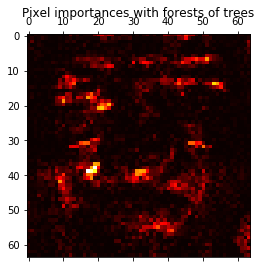

In [11]:
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

# Number of cores to use to perform parallel fitting of the forest model
n_jobs = 1

# Load the faces dataset
data = fetch_olivetti_faces()
X, y = data.data, data.target

mask = y < 5  # Limit to 5 classes
X = X[mask]
y = y[mask]

# Build a forest and compute the pixel importances
print("Fitting ExtraTreesClassifier on faces data with %d cores..." % n_jobs)
t0 = time()
forest = ExtraTreesClassifier(n_estimators=1000,
                              max_features=128,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X, y)
print("done in %0.3fs" % (time() - t0))
# 获得各点的重要性
importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances with forests of trees")
plt.show()

# 3 参考
> [https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModelhttps://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

> [https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

> [https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

> [https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-faces-py](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-faces-py)